In [1]:
import pandas as pd, numpy as np, seaborn as sns, math

from causalinference import CausalModel
from statsmodels.formula.api import ols
from sklearn.neighbors import NearestNeighbors as kNN

### References
- Dataset source: https://sci-hub.se/https://dl.acm.org/doi/10.1145/2764919
- Dataset variables explanation: https://www.kaggle.com/datasets/harrywang/propensity-score-matching/data
- AIPW notebook: https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/aipw.ipynb
- Regularized kNN: https://github.com/arthurmello/regularized-knn

### Load Dataset

In [2]:
data = pd.read_csv("datasets/groupon.csv")
data_control = data[data.treatment==0]
data_treatment = data[data.treatment==1]

In [3]:
data.treatment.value_counts()

0    494
1    216
Name: treatment, dtype: int64

### Student T-test

In [4]:
from scipy.stats import ttest_ind

def student_t_test(
    group_control : list,
    group_treatment : list,
    alpha : float = .05, # confidence level (default)
    *args, **kwargs
) -> dict:
    
    _, p_value = ttest_ind(group_control, group_treatment)
    
    desc = "Failed to reject H0 (same distribution / group mean)." if p_value > alpha \
        else "Reject H0 (different distribution / group mean)."
    
    return {
        "mean_control" : round(np.mean(group_control), 3),
        "mean_treatment" : round(np.mean(group_treatment), 3),
        "p_value" : round(p_value, 3),
        "alpha" : alpha,
        "t_test_description" : desc
    }

In [5]:
student_t_test(data_control.revenue, data_treatment.revenue)

{'mean_control': 9720.988,
 'mean_treatment': 12750.694,
 'p_value': 0.04,
 'alpha': 0.05,
 't_test_description': 'Reject H0 (different distribution / group mean).'}

### Feature Importance using Mutual Information

In [6]:
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot as plt

def select_features(
    X : pd.DataFrame or list or np.array,
    y : pd.DataFrame or list or np.array,
    split_test_size : float = .2,
    random_seed : int = 0,
    sort_results : bool = True,
    plot_fig : bool = True,
    *args, **kwargs
) -> dict:

    # Mutual Information (MI) class
    def mi_classif(X, y):
        return mutual_info_classif(X_train, y_train, random_state=random_seed)
    
    # splitting data training and testing with proportion 80:20 (default)
    X_train, X_test, y_train, y_test= tts(X, y, test_size=split_test_size, random_state=random_seed)
    
    # select K best
    fs = SelectKBest(score_func=mi_classif, k='all')
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    D = dict()
    for i in zip(X_train.columns, fs.scores_):
        D[i[0]] = i[1]

    if sort_results:
        prev_dict = D
        D = dict()
        for j in sorted(prev_dict.items(), key=lambda x: x[1], reverse=True):
            D[j[0]] = j[1]
            
    if plot_fig:
        x_axis_values = [i for i in range(1, len(D)+1)]
        plt.figure(figsize=(10, 5))
        plt.title("Mutual Information-based Feature Importance\nTotal features: {}".format(len(D)))
        plt.bar(x_axis_values, D.values(), color="xkcd:aqua green")
        plt.xticks(x_axis_values, D.keys(), rotation=90)
        plt.ylabel("Feature Score")
        plt.grid(visible=True, axis="y", linestyle='--', color="xkcd:emerald")
        
        plt.savefig(fname="pics/mi_ftr_importance.png", dpi=200, bbox_inches='tight', format="png")
        plt.show()
    
    return D

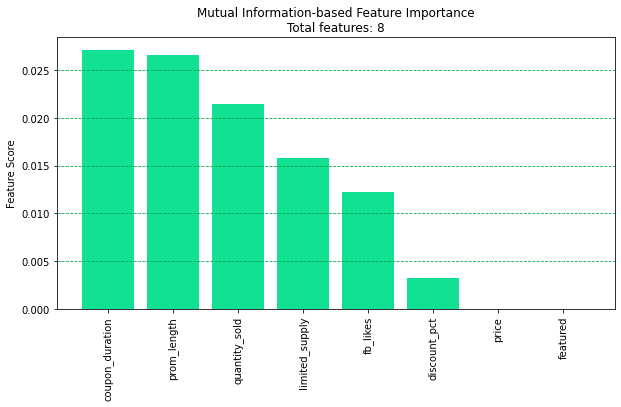

{'coupon_duration': 0.02705455460573636,
 'prom_length': 0.026564149791921565,
 'quantity_sold': 0.02140136895954825,
 'limited_supply': 0.015838365328033177,
 'fb_likes': 0.012222793258617193,
 'discount_pct': 0.0032454469107625616,
 'price': 0.0,
 'featured': 0.0}

In [7]:
# note: 'min_req' should be removed, otherwise the matching won't not working since "treatment" is derived from "min_req"
X_ = data.loc[:, ~data.columns.isin(["deal_id", "start_date", "treatment", "revenue", "min_req"])]
y_ = data["treatment"]

k_best_features = select_features(X_, y_)
k_best_features

### Propensity Score Matching

In [8]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neural_network import MLPClassifier as MLP

In [9]:
def estimate_e(
    X : list, # independent variables (features)
    y : list, # treatment variable
    model_e : LR, # default
    *args, **kwargs
) -> dict:
    
    def apply_logit(p : float, *args, **kwargs) -> float:
        return 0 if p <=0 else math.log(p / (1 - p))
    
    np.random.seed(0) # for reproduciable results
    model = model_e.fit(X, y)
    propensity_score = model.predict_proba(X)[:, 1]
    
    return {
        "model_name" : model_e.__class__.__name__,
        "features" : X.columns.tolist(),
        "ps" : list(propensity_score),
        "ps_logit" : [apply_logit(p) for p in propensity_score]
    }

In [10]:
def plot_ps(
    data : pd.DataFrame,
    estimate_e_results : dict,
    return_new_dataset : bool = False,
    save_fig_fname : str = None,
    *args, **kwargs
) -> pd.DataFrame or None:
    
    # add propensity score to DataFrame
    new_data = data.copy()
    new_data.insert(len(new_data.columns), "ps", estimate_e_results["ps"])
    new_data.insert(len(new_data.columns), "ps_logit", estimate_e_results["ps_logit"])
    
    plt.figure(figsize=(8, 5))
    plt.title("Model = {}\nOverlap distribution plot between Treatment vs. Control" \
        .format(estimate_e_results["model_name"]))
    
    colors = {0 : 'xkcd:electric green', 1 : 'xkcd:electric blue'}
    sns.set(style="darkgrid")
    sns.histplot(data=new_data, x='ps', hue='treatment', bins=30, palette=colors)
    
    if save_fig_fname is not None:
        plt.savefig(fname="pics/plotps_{}.png".format(save_fig_fname), dpi=200, bbox_inches='tight', format="png")
    plt.show()
    
    return new_data if return_new_dataset else None

In [11]:
top_k = 5 # only use 5 top important features
X = data[list(k_best_features.keys())[:top_k]]
y = data.treatment

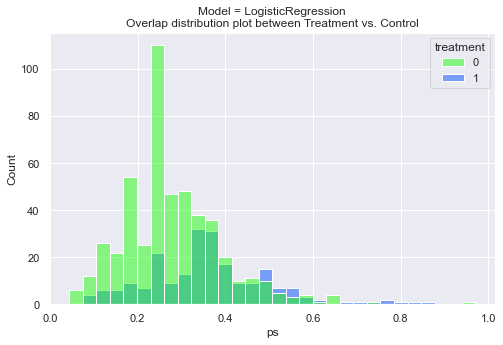

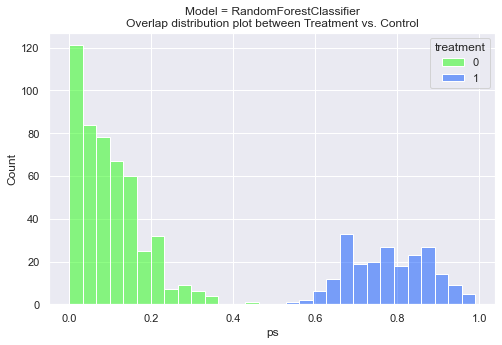

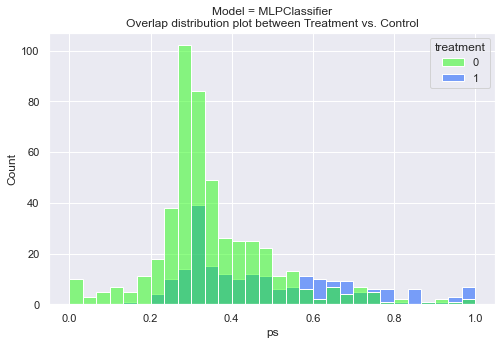

In [35]:
NeuralNet = MLP(hidden_layer_sizes=(64, 32, 16), max_iter=1000)
for model in [LR(), RFC(), NeuralNet]:
    plot_ps(data, estimate_e(X, y, model), save_fig_fname=model.__class__.__name__)

### Find Matching Points using Unsupervised kNN (using kD-Tree algorithm)

In [13]:
def find_matching_points(
    ps : list, # a list of propensity scores
    dataset : pd.DataFrame,
    knn_neighbors : int = 10,
    *args, **kwargs
) -> dict:
    
    # reshape from the list into [[...], [...], [...], ...]
    ps = [[i] for i in ps]
    
    # In short, caliper is a tunable parameter acts as a "filter" for the propensity score.
    # More formally, calipers act as "tolerance thresholds" for the difference in propensity scores
    #    between matched subjects. A narrow caliper imposes strict similarity requirements, leading to
    #    highly comparable pairs but potentially discarding valuable data and reducing statistical power.
    # Here, we use 25% (0.25) of the standard deviation of the propensity score as a caliper.
    caliper = np.std(ps) * .25
    
    # initiate kNN algorithm
    knn = kNN(n_neighbors=knn_neighbors, radius=caliper, algorithm="kd_tree")
    knn.fit(ps)
    distances, neighbor_indexes = knn.kneighbors(ps)
    
    # for each point in treatment, find a matching point in control without replacement
    # note the 10 neighbors may include both points in treatment and control
    df = dataset.copy()
    matched_control = []
    
    for current_index, row in df.iterrows():
        if row.treatment == 0: # control group
            df.loc[current_index, 'matched'] = np.nan # set the new column "matched" to NaN

        elif row.treatment == 1: # treatment group 
            for idx in neighbor_indexes[current_index, :]:
                # for each row in treatment, find the k neighbors.
                # make sure the current row is not the idx.
                # do not match to itself and the neighbor is in the control.
                if (current_index != idx) and (df.loc[idx].treatment == 0):
                    if idx not in matched_control:  # this control has not been matched yet
                        df.loc[current_index, 'matched'] = idx  # record the matching
                        matched_control.append(idx)  # add the matched to the list
                        break

    # Treatment (Control that have no match)
    treatment_matched = df.dropna(subset=['matched'])
    
    # Control that have match
    control_matched_idx = treatment_matched.matched.astype(int) # get matched indexes
    control_matched = df.loc[control_matched_idx, :] # select matched control observations
    
    # Treatment + Control after matching
    df_matched = pd.concat([treatment_matched, control_matched])
    
    # END NOTE:
    # Adjust the number of neighbors
    # or caliper to get more matches
    
    return {
        "df" : df,
        "total_matched_obs_in_control" : len(matched_control),
        "dataset_matched" : df_matched,
        "knn_distances" : distances,
        "knn_neighbor_idx" : neighbor_indexes
    }

In [14]:
mlp_result = estimate_e(X, y, NeuralNet)
mt = find_matching_points(ps=mlp_result["ps"], dataset=data)

In [15]:
mt["total_matched_obs_in_control"]

178

In [16]:
data_matched = mt["dataset_matched"]
print("Treatment vs. Control after matching:")
print(data_matched.treatment.value_counts())

Treatment vs. Control after matching:
1    178
0    178
Name: treatment, dtype: int64


In [17]:
# matched control and treatment
data_matched_control = data_matched[data_matched.treatment==0]
data_matched_treatment = data_matched[data_matched.treatment==1]

# recalculate t-test after matching
student_t_test(data_matched_control.revenue, data_matched_treatment.revenue)

{'mean_control': 13712.77,
 'mean_treatment': 10498.764,
 'p_value': 0.097,
 'alpha': 0.05,
 't_test_description': 'Failed to reject H0 (same distribution / group mean).'}

### Distribution Check using SMDs

In [18]:
def calc_smds(
    data : pd.DataFrame,
    covariates : list,
    *args, **kwargs
) -> dict:
    
    # To check if distribution of relevant covariates are still well-balanced AFTER matching
    # using Standardized Mean Differences (SMDs).
    
    # Aim for SMDs close to zero (ideally below 0.1) after matching,
    # indicating minimal differences in covariate distributions.
    
    SMDs = dict()
    for cv in covariates:
        treatment_mean = data[data.treatment == 1][cv].mean()
        treatment_std = data[data.treatment == 1][cv].std()
        control_mean = data[data.treatment == 0][cv].mean()
        control_std = data[data.treatment == 0][cv].std()

        # calculate SMDs
        SMDs[cv] = (treatment_mean - control_mean) / (treatment_std + control_std)
    
    return SMDs

* Before matching

In [19]:
calc_smds(data, X.columns)

{'coupon_duration': 0.14135287337660787,
 'prom_length': -0.1641617795505339,
 'quantity_sold': 0.1261630449786088,
 'limited_supply': -0.09644391802297005,
 'fb_likes': 0.11271885949457035}

* After matching (which is good, since all **SMDs <= 0.1**)

In [20]:
calc_smds(data_matched, X.columns)

{'coupon_duration': -0.015514382967955136,
 'prom_length': -0.17286306561933565,
 'quantity_sold': -0.08062434087551573,
 'limited_supply': 0.0,
 'fb_likes': -0.08169241547160067}

### Examine the Effect Size of Both Groups

In [21]:
def cohen_d(
    d1 : list,
    d2 : list,
    *args, **kwargs
) -> float:
    
    # This is a function to calculate Cohen's d for independent samples.
    # ref: https://en.wikipedia.org/wiki/Effect_size#Cohen's_d

    # How to read a Cohen's d value?
    # - Magnitude: For instance, an effect size of -0.328313 is considered a medium negative effect
    #      according to Cohen's d thresholds. This means that, on average, a one-unit increase in
    #      the variable would be associated with a decrease of 0.33 units in the outcome variable.
    #
    # - Direction: The negative sign (-) means that the relationship between the variable and
    #      the outcome is inversely proportional. In other words, as the variable increases,
    #      the outcome decreases, and vice versa.

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)

    # calculate the effect size
    return (u1 - u2) / s

In [22]:
def calc_effect_size(
    data_control : pd.DataFrame,
    data_treatment : pd.DataFrame,
    data_matched_control : pd.DataFrame,
    data_matched_treatment : pd.DataFrame,
    *args, **kwargs
) -> pd.DataFrame:
    
    effect_sizes = []
    for cl in X.columns:
        _, p_before = ttest_ind(data_control[cl], data_treatment[cl])
        _, p_after = ttest_ind(data_matched_control[cl], data_matched_treatment[cl])

        cohen_d_before = cohen_d(data_treatment[cl], data_control[cl])
        cohen_d_after = cohen_d(data_matched_treatment[cl], data_matched_control[cl])

        effect_sizes.append([cl,'before', cohen_d_before, p_before])
        effect_sizes.append([cl,'after', cohen_d_after, p_after])
        
    
    return pd.DataFrame(effect_sizes, columns=['feature', 'matching', 'effect_size', 'p-value'])

In [23]:
def calc_effect_size_diff(
    data : pd.DataFrame,
    *args, **kwargs
) -> pd.DataFrame:

    # Look for features where the effect size decreased substantially after matching.
    # This suggests that the matching process successfully controlled for confounding variables
    # that were influencing the effect size before matching.

    # Generally, a decrease of 0.2 or more in Cohen's d is considered a moderate reduction
    # in effect size, indicating potential bias reduction.

    differences = dict()
    for _, i in data.groupby("feature"):
        cohen_before = i[i.matching=="before"].effect_size.values[0]
        cohen_after = i[i.matching=="after"].effect_size.values[0]

        ftr_name = list(set(i.feature.values))[0]
        differences[ftr_name] = cohen_before-cohen_after

    return differences

In [24]:
df_effect_sizes = calc_effect_size(data_control, data_treatment, data_matched_control, data_matched_treatment)
df_effect_sizes

,feature,matching,effect_size,p-value
0,coupon_duration,before,0.282300,0.000571
1,coupon_duration,after,-0.030755,0.771875
2,prom_length,before,-0.328313,0.000063
3,prom_length,after,-0.345716,0.001216
4,quantity_sold,before,0.267669,0.001084
5,quantity_sold,after,-0.156860,0.139812
6,limited_supply,before,-0.198547,0.015178
7,limited_supply,after,0.000000,1.000000
8,fb_likes,before,0.235855,0.003953
9,fb_likes,after,-0.159086,0.134294


In [25]:
calc_effect_size_diff(df_effect_sizes)

{'coupon_duration': 0.3130549377516118,
 'fb_likes': 0.39494171239927645,
 'limited_supply': -0.19854708284616845,
 'prom_length': 0.017402939578402332,
 'quantity_sold': 0.4245290855630939}

In [26]:
def plot_cohen(
    data : pd.DataFrame,
    title_model_name : str,
    rounded : bool = True,
    save_fig : bool = True,
    *args, **kwargs
) -> None:

    if rounded:
        # round the effect size values
        data_rounded = data.copy()
        data_rounded["effect_size"] = data_rounded.effect_size.apply(lambda x: round(x, 3))

    # compare the Cohen's d values before and after matching
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.title("Model = {}\nThe Effect Size Comparison BEFORE and AFTER Matching".format(title_model_name))

    ax = sns.barplot(
        data=data_rounded,
        x='effect_size',
        y='feature',
        hue='matching', 
        orient='h',
        saturation=.9,
        palette=sns.color_palette('bright')[1:3]
    )
    ax.bar_label(ax.containers[0], fontsize=10)
    ax.bar_label(ax.containers[1], fontsize=10)
    
    if save_fig:
        plt.savefig(fname="pics/plotcohen_{}.png".format(title_model_name), dpi=200, bbox_inches='tight', format="png")
    plt.show()

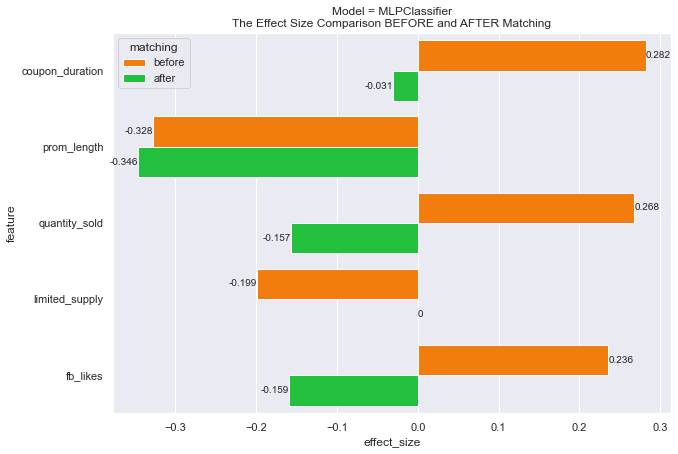

In [27]:
plot_cohen(df_effect_sizes, "MLPClassifier")

### Comparison with Other Algorithms

=========== LogisticRegression ===========
Total match: 184
 - mean_control: 12707.647
 - mean_treatment: 12621.196
 - p_value: 0.97
 - alpha: 0.05
 - t_test_description: Failed to reject H0 (same distribution / group mean).

Cohen's d effect size:
           feature matching  effect_size   p-value
0  coupon_duration   before     0.282300  0.000571
1  coupon_duration    after    -0.082376  0.429966
2      prom_length   before    -0.328313  0.000063
3      prom_length    after    -0.108466  0.298855
4    quantity_sold   before     0.267669  0.001084
5    quantity_sold    after     0.016266  0.876102
6   limited_supply   before    -0.198547  0.015178
7   limited_supply    after     0.129408  0.215314
8         fb_likes   before     0.235855  0.003953
9         fb_likes    after    -0.029857  0.774753

 - coupon_duration: 0.365
 - fb_likes: 0.266
 - limited_supply: -0.328
 - prom_length: -0.220
 - quantity_sold: 0.251



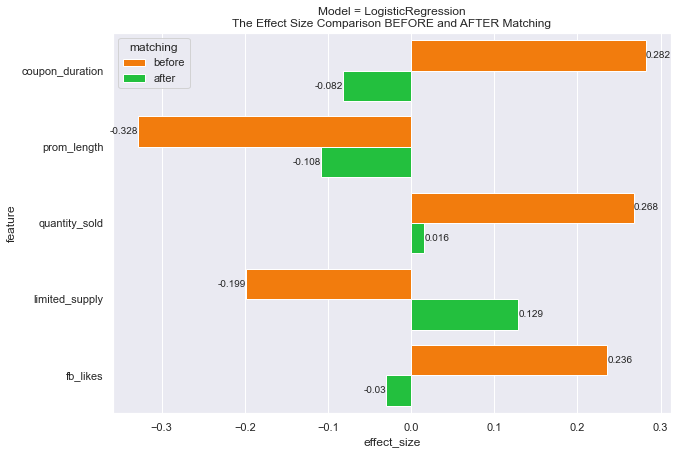


=========== RandomForestClassifier ===========
Total match: 0
 - mean_control: nan
 - mean_treatment: nan
 - p_value: nan
 - alpha: 0.05
 - t_test_description: Reject H0 (different distribution / group mean).

Cohen's d effect size:
           feature matching  effect_size   p-value
0  coupon_duration   before     0.282300  0.000571
1  coupon_duration    after          NaN       NaN
2      prom_length   before    -0.328313  0.000063
3      prom_length    after          NaN       NaN
4    quantity_sold   before     0.267669  0.001084
5    quantity_sold    after          NaN       NaN
6   limited_supply   before    -0.198547  0.015178
7   limited_supply    after          NaN       NaN
8         fb_likes   before     0.235855  0.003953
9         fb_likes    after          NaN       NaN

 - coupon_duration: nan
 - fb_likes: nan
 - limited_supply: nan
 - prom_length: nan
 - quantity_sold: nan



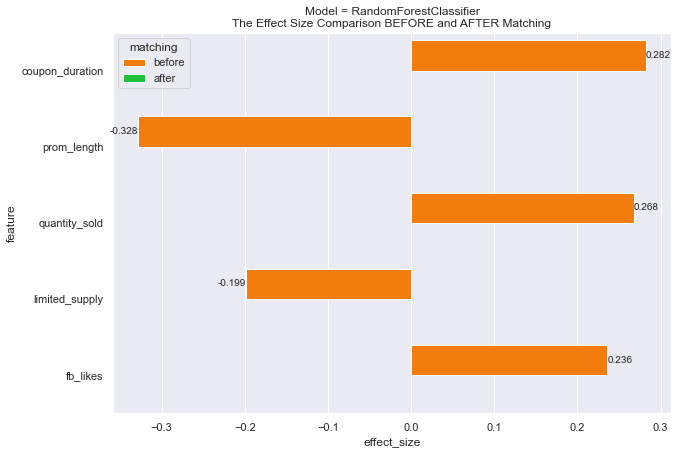


=========== MLPClassifier ===========
Total match: 178
 - mean_control: 13712.77
 - mean_treatment: 10498.764
 - p_value: 0.097
 - alpha: 0.05
 - t_test_description: Failed to reject H0 (same distribution / group mean).

Cohen's d effect size:
           feature matching  effect_size   p-value
0  coupon_duration   before     0.282300  0.000571
1  coupon_duration    after    -0.030755  0.771875
2      prom_length   before    -0.328313  0.000063
3      prom_length    after    -0.345716  0.001216
4    quantity_sold   before     0.267669  0.001084
5    quantity_sold    after    -0.156860  0.139812
6   limited_supply   before    -0.198547  0.015178
7   limited_supply    after     0.000000  1.000000
8         fb_likes   before     0.235855  0.003953
9         fb_likes    after    -0.159086  0.134294

 - coupon_duration: 0.313
 - fb_likes: 0.395
 - limited_supply: -0.199
 - prom_length: 0.017
 - quantity_sold: 0.425



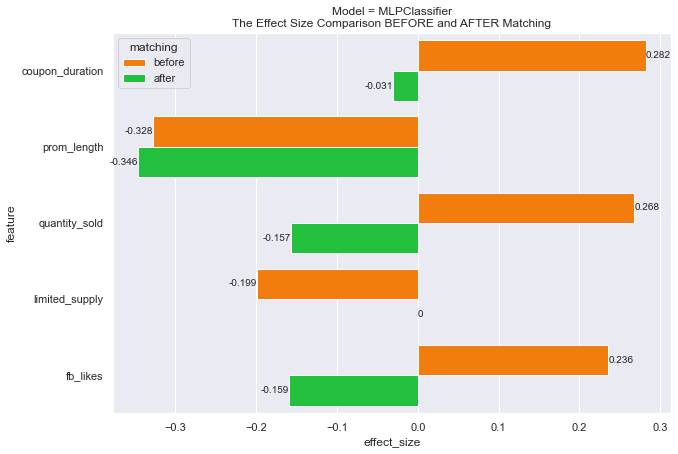

In [37]:
for idx, m in enumerate([LR(), RFC(), NeuralNet]):
    m_name = m.__class__.__name__
    print("=========== {} ===========".format(m_name))
    
    est_result = estimate_e(X, y, m)
    mtch_result = find_matching_points(ps=est_result["ps"], dataset=data)
    print("Total match: {}".format(mtch_result["total_matched_obs_in_control"]))
    
    # matched control and treatment
    data_mtch = mtch_result["dataset_matched"]
    data_mtch_control = data_mtch[data_mtch.treatment==0]
    data_mtch_treatment = data_mtch[data_mtch.treatment==1]

    # recalculate t-test after matching
    for k_st, v_st in student_t_test(data_mtch_control.revenue, data_mtch_treatment.revenue).items():
        print(" - {}: {}".format(k_st, v_st))
        
    # cohen's d
    print("\nCohen's d effect size:")
    eff = calc_effect_size(data_control, data_treatment, data_mtch_control, data_mtch_treatment)
    print(eff, end="\n\n")
    for k_eff, v_eff in calc_effect_size_diff(eff).items():
        print(" - {}: {:.3f}".format(k_eff, round(v_eff, 3)))
    
    print()
    plot_cohen(eff, m_name)
    
    print()

In [29]:
# Create a causal model
# model = CausalModel(Y=data.revenue.to_numpy(), D=data.treatment.to_numpy(), X=data[ind_vars].to_numpy())

In [30]:
# Fit outcome models for treated and control groups
# model_t = ols("outcome_var ~ X1 + X2 + ...", data=model.data[model.data[treatment] == 1]).fit()
# model_c = ols("outcome_var ~ X1 + X2 + ...", data=model.data[model.data[treatment] == 0]).fit()

In [31]:
# model.est_propensity_s()

In [32]:
# model.propensity.keys()

In [33]:
# Calculate AIPW weights manually
# pscores = model.propensity
# y = model.data[outcome]
# t = model.data[treatment]

In [34]:
# weights = (t / pscores) + ((1 - t) / (1 - pscores)) * model_c.predict(model.data) / model_t.predict(model.data)

# Estimate the average treatment effect (ATE)
# ate = model.estimate_effect(weights=weights)

# print("Estimated ATE:", ate)